In [8]:
import pandas as pd
import seaborn as sb
import seaborn.objects as so
import utils as utils
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
%reload_ext autoreload
%autoreload 2

In [3]:
df=utils.get_df('data.csv')
sales=utils.get_df('sales.csv')

X_train, X_test, y_train, y_test = train_test_split(df[['yearbuilt','universalsize','beds','bathstotal','zipcode']],sales['saleamt'], test_size=0.3)

In [4]:
#Decision Tree creatation
clf = HistGradientBoostingClassifier()

clf.fit(X_train, y_train)

predications = clf.predict(X_test)

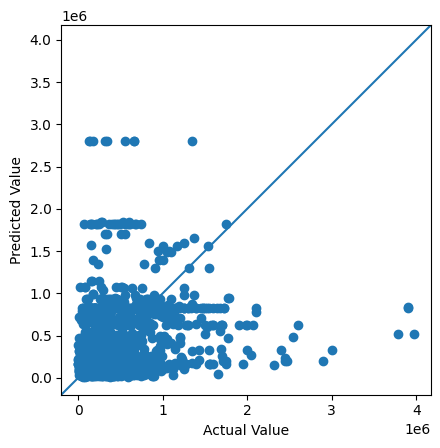

In [5]:
fig, ax=plt.subplots()
ax.scatter(x=y_test,y=predications)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline((0, 0), slope=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
fig.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError as rms
from tensorflow.keras.metrics import MeanAbsoluteError as mae
from tensorflow.keras.optimizers import Adam


Epoch 42: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
12/12 [==============================] - 0s 1ms/step
        saleamt
3424   266500.0
3425    20000.0
3426   350000.0
3427  1775000.0
3428   600000.0
...         ...
3801   210000.0
3802   535000.0
3803   100000.0
3804  1325000.0
3805   875000.0

[382 rows x 1 columns]


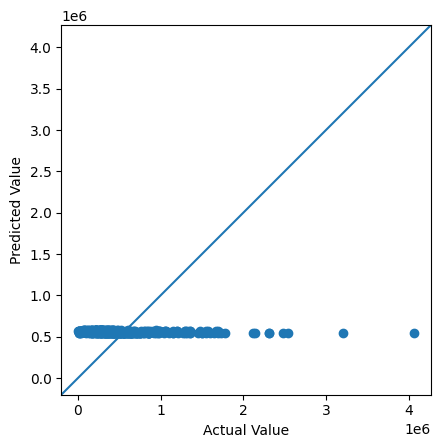

In [29]:
data=utils.get_df('data.csv')
sales=utils.get_df('sales.csv')
data=pd.concat([data, sales['saleamt']],axis = 1)
data=data[['yearbuilt','universalsize','beds','bathstotal','zipcode','saleamt']]
data=data.dropna(axis=0)
inNames=['yearbuilt','universalsize','beds','bathstotal','zipcode']
outNames=['saleamt']
normData, minVal, maxVal = utils.minNormalize(data)
train, val, test = utils.splitData(normData, seed=142)

# set hyperparams
# variables to tune
epochs = 500
batch = 120
p = 10
nlayers = 6
mindelta = 1e-5
LR = 1e-4

# build the model
# build the model
model = utils.buildModel(nlayers,
                   metrics=[rms(), mae()],
                   optimizer=Adam(learning_rate=LR))

# fit the model
# stop the model if the validation loss levels off
cb = EarlyStopping(monitor='val_loss',
                   min_delta=mindelta,
                   patience=p,
                   restore_best_weights=True)

# reduce learning rate to try to improve results
lrCalib = ReduceLROnPlateau(monitor='val_loss',
                            factor=1e-2,
                            patience=5,
                            cooldown=5,
                            verbose=1)

# fit the model using the above two callbacks
hist = model.fit(train[inNames], train[outNames],
                 validation_data=(val[inNames], val[outNames]),
                 epochs=epochs,
                 batch_size=batch,
                 verbose=0,
                 callbacks=[cb, lrCalib])

# test with testing data
# predict with model and testing values
predNorm = model.predict(test[inNames])
pred = utils.inverseMinNormalize(predNorm, minVal, maxVal)
trueamt=utils.inverseMinNormalize(test[outNames], minVal, maxVal)
fig, ax=plt.subplots()
ax.scatter(x=trueamt,y=pred)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline((0, 0), slope=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
fig.show()